In [1]:
import os

import healpy as hp
import numpy as np
import skyproj
import proplot as pplt
import matplotlib.pyplot as plt
import fitsio

import rubin_sim
from rubin_sim import maf
from rubin_sim.scheduler.utils import Sky_area_generator
from rubin_sim.utils import raDec2Hpid

In [2]:
def mad(x, axis=None, no_scale=False):
    """
    median absolute deviation - scaled like a standard deviation

        mad = 1.4826*median(|x-median(x)|)

    Parameters
    ----------
    x: array-like
        array to take MAD of
    axis: int
        axis over which to take mode (default: None)
    no_scale: bool
        return MAD not scaled to match a Gaussian (default: False)

    Returns
    -------
    mad: float
        MAD of array x
    """
    kd = True if axis is not None else False
    mad = np.median(np.abs(x - np.median(x, axis=axis, keepdims=kd)), axis=axis)
    if no_scale:
        return mad
    else:
        return 1.4826 * mad

In [3]:
nside = 128

sm = Sky_area_generator(nside=nside)
footprints_hp_array, labels = sm.return_maps()
wfd_indx = np.where((labels == 'lowdust') | (labels == 'virgo'))[0]

In [4]:
def compute_map_stats(maps_arr, noroll_maps_arr):

    mdata = np.zeros(
        len(maps_arr),
        dtype=[
            (col, "f8", (2,))
            for col in [
                "med",
                "sd",
                "pt",
                "area",
            ]
        ] + [
            (col, "f8")
            for col in ["tlost", "alost"]
        ],
    )
    
    for i in range(len(maps_arr)):
        fmaps = maps_arr[i].copy()
        fmaps[~wfd_indx] = -9999
        fmaps = fmaps[fmaps > 15]
        if fmaps.shape == (0,):
            continue
        
        fnoroll_maps = noroll_maps_arr[i].copy()
        fnoroll_maps[~wfd_indx] = -9999        
        fnoroll_maps = fnoroll_maps[fnoroll_maps > 15]

        if fnoroll_maps.shape == (0,):
            continue
            
        mdata["med"][i, 0] = np.median(fmaps)
        mdata["med"][i, 1] = np.median(fnoroll_maps)

        mdata["sd"][i, 0] = mad(fmaps)
        mdata["sd"][i, 1] = mad(fnoroll_maps)
        
        ptval = 25
        mdata["pt"][i, 0] = np.percentile(fmaps, [ptval])
        mdata["pt"][i, 1] = np.percentile(fnoroll_maps, [ptval])
        
        mdata["tlost"][i] = (mdata["pt"][i, 1] - mdata["pt"][i, 0])/mdata["pt"][i, 1]

        ns = 3
        mn = np.median(fnoroll_maps)
        _sd = mad(fnoroll_maps)
        cut = mn-ns*_sd
        cut = mdata["pt"][i, 1]
        mdata["area"][i, 0] = np.sum(fmaps > cut)
        mdata["area"][i, 1] = np.sum(fnoroll_maps > cut)
        mdata["alost"][i] = (
            (mdata["area"][i, 1] - mdata["area"][i, 0])/mdata["area"][i, 1]
        )

    return mdata

In [6]:
noroll_maps_arr = fitsio.read("noroll_v2.2_10yrs_nside128_bins40.fits")
baseline_maps_arr = fitsio.read("baseline_v2.2_10yrs_nside128_bins40.fits")

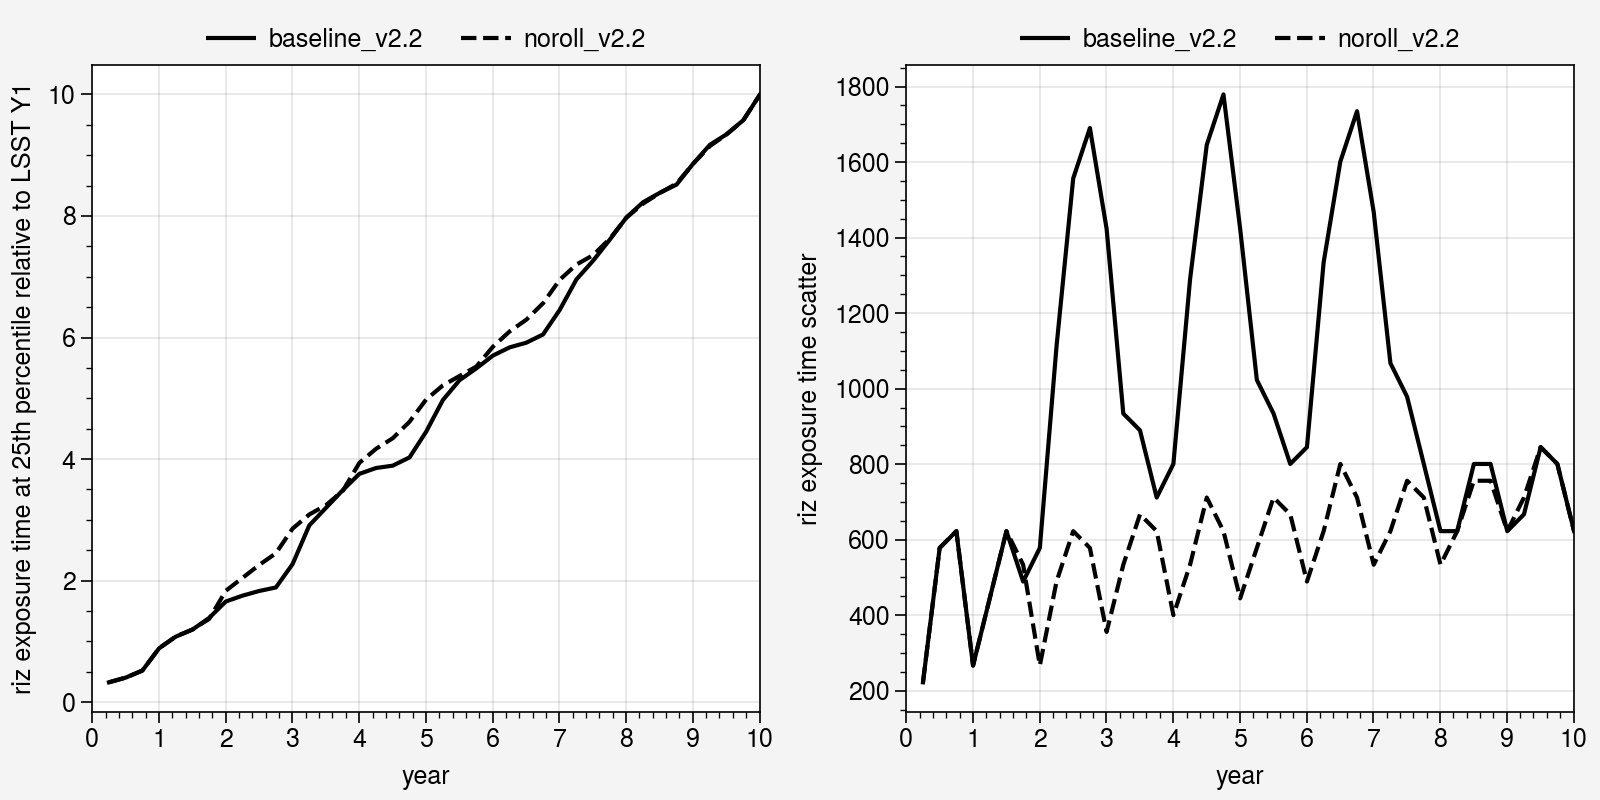

In [7]:
import proplot as pplt
import glob

alpha = 1

rlabel = "baseline_v2.2"
nrlabel = "noroll_v2.2"

fig, axs = pplt.subplots(ncols=2, nrows=1, figsize=(8, 4), sharey=0, sharex=0)

maps_arr = baseline_maps_arr.copy()
i = 0
mdata = compute_map_stats(maps_arr, noroll_maps_arr)

xy = np.linspace(0, 3653, 41)[1:]/365

#     axs[0, 0].plot(xy, mdata["tlost"], 'k', label="depth" if i == 0 else None, alpha=alpha)
#     axs[0, 0].plot(xy, mdata["alost"], 'k--', label="area" if i == 0 else None, alpha=alpha)
#     axs[0, 0].set_ylabel("frac depth or area lost at 25th percentile")
#     if i == 0:
#         axs[0, 0].legend(loc='t', frameon=False)

axs[0].plot(
    xy, 
    mdata["pt"][:, 0]/(mdata["pt"][-1, 0]/10), 
    'k', 
    label=rlabel if i == 0 else None,
    alpha=alpha,
)
#     if i == 0:
#         axs[0].plot(
#             [0, 10], 
#             [0, 10], 
#             'k:', 
#             label="uniform" if i == 0 else None,
#         )
if i == 0:
    axs[0].plot(xy, mdata["pt"][:, 1]/(mdata["pt"][-1, 1]/10), 'k--', label=nrlabel if i == 0 else None)
axs[0].set_ylabel("riz exposure time at 25th percentile relative to LSST Y1")
if i == 0:
    axs[0].legend(loc="t", frameon=False)

#     axs[1, 0].plot(xy, mdata["pt"][:, 1] - mdata["pt"][:, 0], 'k', alpha=alpha)
#     axs[1, 0].set_ylabel("rolling riz exposure time deficit at 25th percentile [sec]")

axs[1].plot(xy, mdata["sd"][:, 0], 'k', label=rlabel if i == 0 else None, alpha=alpha)
if i == 0:
    axs[1].plot(xy, mdata["sd"][:, 1], 'k--', label=nrlabel if i == 0 else None)
axs[1].set_ylabel("riz exposure time scatter")
if i == 0:
    axs[1].legend(loc="t", frameon=False)

for ax in axs:
    ax.set_xlim(0, 10)
    ax.set_xlabel("year")
    ax.format(xticks=np.arange(0, 11))

fig.savefig(rlabel + ".png", dpi=300)

### Check gap years

In [10]:
scale = 0.9
nslice = 2
roll_indx = 4

down = 1.0 - scale
up = nslice - down * (nslice - 1)
start = [1.0, 1.0]
end = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

rollings = [[1.0, up, down, 1, up, down, 1, up, down],
            [1.0, up, down, 1, 1, up, down, up, down],
            [1.0, up, down, 1, up, down, up, down],
            [up, down, 1, 1, up, down, up, down],
            [up, down, 1, up, down, 1, up, down],
            [up, down, 1, up, down, up, down],
            [up, down, 1, 1, up, down, up, down, up, down],
            [up, down, 1, up, down, 1, up, down, up, down],
            [up, down, 1, up, down, up, down, up, down],
            ]

temp_all_slopes = [start + np.roll(rollings[roll_indx], i).tolist() + end for i in range(nslice)]
all_slopes_1 = []
all_slopes_2 = []
for i in range(len(temp_all_slopes[0])):
    all_slopes_1.append(temp_all_slopes[0][i])
    all_slopes_2.append(2.0 - temp_all_slopes[0][i])      
all_slopes = [all_slopes_1, all_slopes_2]

print("roll_indx:", roll_indx)
for i in range(len(all_slopes[0])):
    print("year %2d: %0.2f %0.2f" % (i+1, all_slopes[0][i], all_slopes[1][i]))

roll_indx: 4
year  1: 1.00 1.00
year  2: 1.00 1.00
year  3: 1.90 0.10
year  4: 0.10 1.90
year  5: 1.00 1.00
year  6: 1.90 0.10
year  7: 0.10 1.90
year  8: 1.00 1.00
year  9: 1.90 0.10
year 10: 0.10 1.90
year 11: 1.00 1.00
year 12: 1.00 1.00
year 13: 1.00 1.00
year 14: 1.00 1.00
year 15: 1.00 1.00
year 16: 1.00 1.00


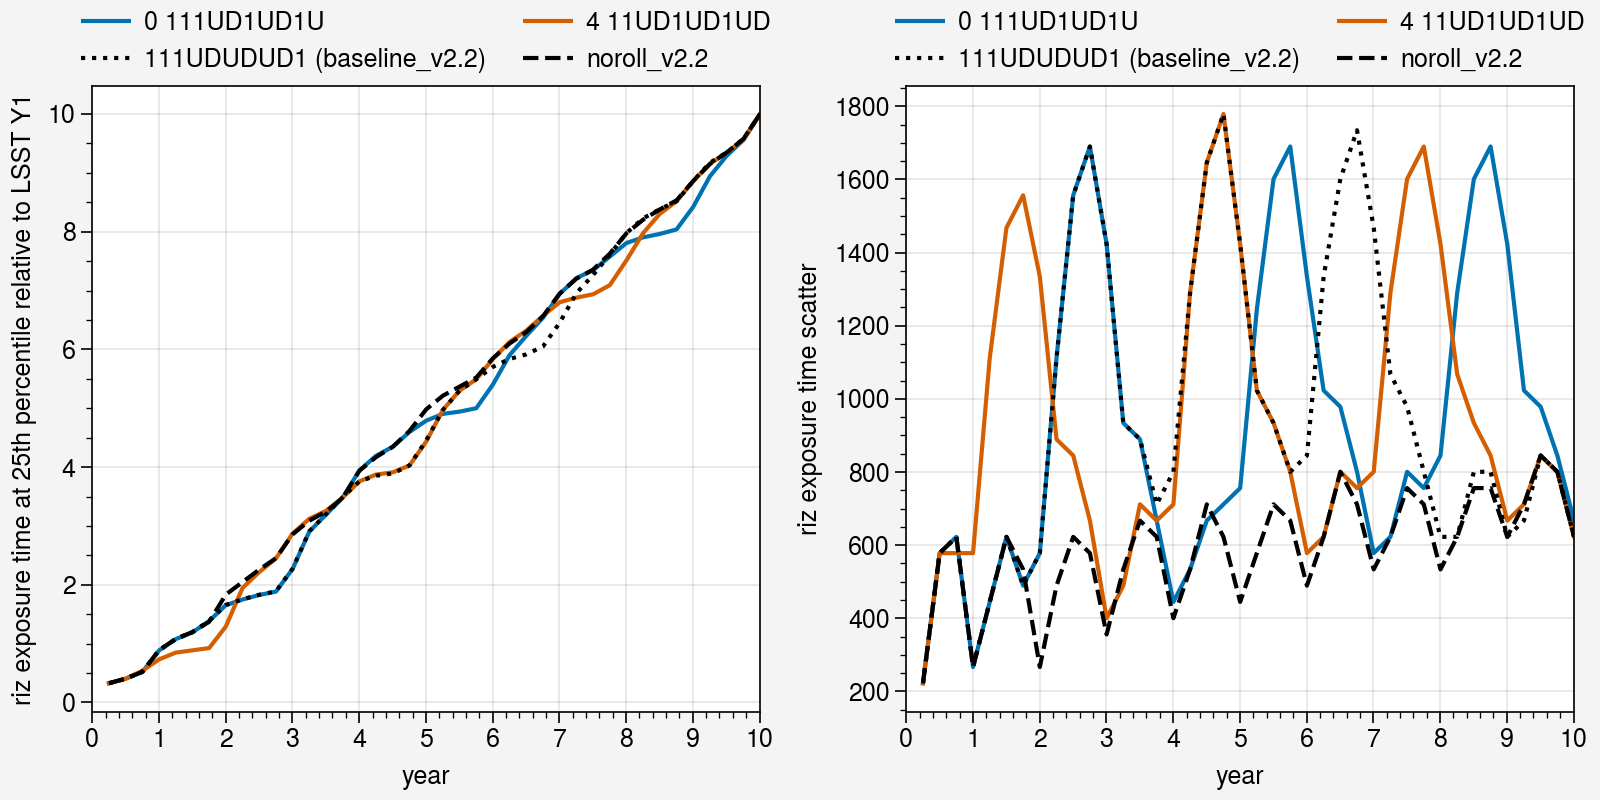

In [32]:
import proplot as pplt
import glob

alpha = 1

rlabel = "111UDUDUD1 (baseline_v2.2)"
nrlabel = "noroll_v2.2"
bl_mdata = compute_map_stats(baseline_maps_arr.copy(), noroll_maps_arr)


fig, axs = pplt.subplots(ncols=2, nrows=1, figsize=(8, 4), sharey=0, sharex=0)

# start = [1.0, 1.0]
# end = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

up = 2
down = 3

rollings = [[1.0, up, down, 1, up, down, 1, up, down], #0
            [1.0, up, down, 1, 1, up, down, up, down], #1
            [1.0, up, down, 1, up, down, up, down],    #2
            [up, down, 1, 1, up, down, up, down],      #3
            [up, down, 1, up, down, 1, up, down],      #4
            [up, down, 1, up, down, up, down],         #5
            [up, down, 1, 1, up, down, up, down, up, down], # 6
            [up, down, 1, up, down, 1, up, down, up, down], #7
            [up, down, 1, up, down, up, down, up, down], #8
            ]

patterns = []
for roll in rollings:
    pat = "11"
    for el in roll:
        if el == 1.0:
            pat += "1"
        elif el == 2:
            pat += "U"
        elif el == 3:
            pat += "D"
        else:
            raise RuntimeError("el is bad %s" % el)
    pat += "111111"
    patterns.append(pat[:10])

# print(patterns)
inds_to_plot = [0, 4]

fnames = sorted(glob.glob("roll_with_const_roll_indx*.fits"))
for i, fname in enumerate(fnames):
    if i not in inds_to_plot + [len(fnames)-1]:
        continue
    # print(i, fname)
    maps_arr = fitsio.read(fname)
    mdata = compute_map_stats(maps_arr, noroll_maps_arr)

    xy = np.linspace(0, 3653, 41)[1:]/365
    
#     axs[0, 0].plot(xy, mdata["tlost"], 'k', label="depth" if i == 0 else None, alpha=alpha)
#     axs[0, 0].plot(xy, mdata["alost"], 'k--', label="area" if i == 0 else None, alpha=alpha)
#     axs[0, 0].set_ylabel("frac depth or area lost at 25th percentile")
#     if i == 0:
#         axs[0, 0].legend(loc='t', frameon=False)

    if i in inds_to_plot:
        axs[0].plot(
            xy, 
            mdata["pt"][:, 0]/(mdata["pt"][-1, 0]/10),
            label="%d " % i + patterns[i],
            alpha=alpha,
        )
#     if i == 0:
#         axs[0].plot(
#             [0, 10], 
#             [0, 10], 
#             'k:', 
#             label="uniform" if i == 0 else None,
#         )
    if i == len(fnames)-1:
        axs[0].plot(xy, bl_mdata["pt"][:, 0]/(bl_mdata["pt"][-1, 0]/10), 'k:', label=rlabel)
        axs[0].plot(xy, mdata["pt"][:, 1]/(mdata["pt"][-1, 1]/10), 'k--', label=nrlabel)
        axs[0].set_ylabel("riz exposure time at 25th percentile relative to LSST Y1")
        axs[0].legend(loc="t", frameon=False, ncol=2)

#     axs[1, 0].plot(xy, mdata["pt"][:, 1] - mdata["pt"][:, 0], 'k', alpha=alpha)
#     axs[1, 0].set_ylabel("rolling riz exposure time deficit at 25th percentile [sec]")

    if i in inds_to_plot:
        axs[1].plot(xy, mdata["sd"][:, 0], label="%d " % i + patterns[i], alpha=alpha)
    if i == len(fnames)-1:
        axs[1].plot(xy, bl_mdata["sd"][:, 0], 'k:', label=rlabel)
        axs[1].plot(xy, mdata["sd"][:, 1], 'k--', label=nrlabel)
    axs[1].set_ylabel("riz exposure time scatter")
    if i == len(fnames)-1:
        axs[1].legend(loc="t", frameon=False, ncol=2)

    for ax in axs:
        ax.set_xlim(0, 10)
        ax.set_xlabel("year")
        ax.format(xticks=np.arange(0, 11))
        
fig.savefig("roll_with_const_inds" + "_".join("%s" % itp for itp in inds_to_plot) + ".png", dpi=300)

### Look at Clouds

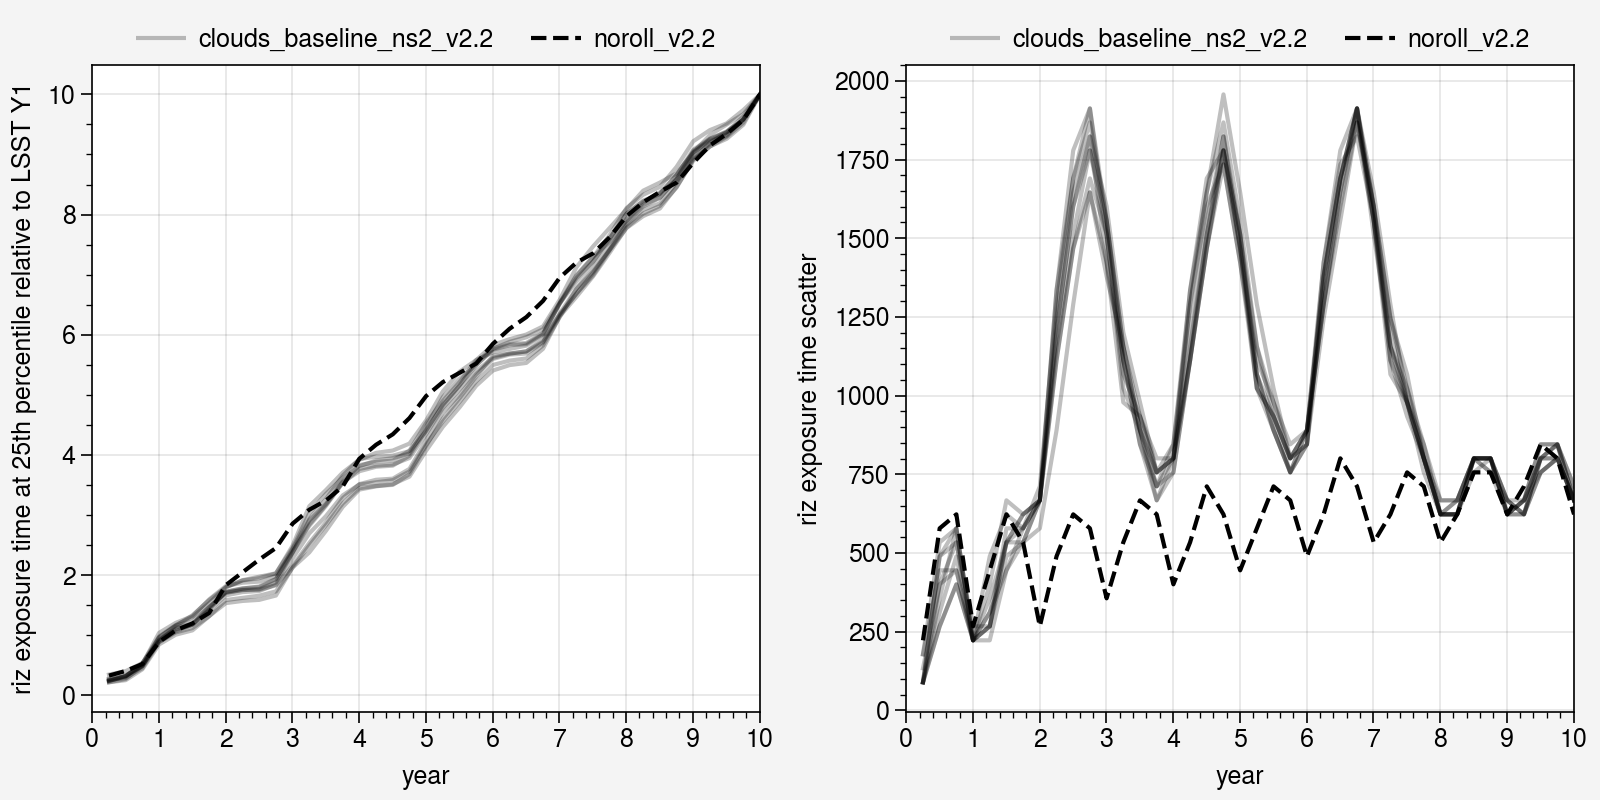

In [28]:
import proplot as pplt
import glob

alpha = 0.25

rlabel = "clouds_baseline_ns2_v2.2"
nrlabel = "noroll_v2.2"
maps_arr = baseline_maps_arr.copy()

fig, axs = pplt.subplots(ncols=2, nrows=1, figsize=(8, 4), sharey=0, sharex=0)

fnames = glob.glob("clouds_baseline_cloudso*_ns2_v2.2_10yrs_nside128_bins40.fits")
for i, fname in enumerate(fnames):
    maps_arr = fitsio.read(fname)
    mdata = compute_map_stats(maps_arr, noroll_maps_arr)

    xy = np.linspace(0, 3653, 41)[1:]/365
    
#     axs[0, 0].plot(xy, mdata["tlost"], 'k', label="depth" if i == 0 else None, alpha=alpha)
#     axs[0, 0].plot(xy, mdata["alost"], 'k--', label="area" if i == 0 else None, alpha=alpha)
#     axs[0, 0].set_ylabel("frac depth or area lost at 25th percentile")
#     if i == 0:
#         axs[0, 0].legend(loc='t', frameon=False)

    axs[0].plot(
        xy, 
        mdata["pt"][:, 0]/(mdata["pt"][-1, 0]/10), 
        'k', 
        label=rlabel if i == 0 else None,
        alpha=alpha,
    )
#     if i == 0:
#         axs[0].plot(
#             [0, 10], 
#             [0, 10], 
#             'k:', 
#             label="uniform" if i == 0 else None,
#         )
    if i == 0:
        axs[0].plot(xy, mdata["pt"][:, 1]/(mdata["pt"][-1, 1]/10), 'k--', label=nrlabel if i == 0 else None)
    axs[0].set_ylabel("riz exposure time at 25th percentile relative to LSST Y1")
    if i == 0:
        axs[0].legend(loc="t", frameon=False)

#     axs[1, 0].plot(xy, mdata["pt"][:, 1] - mdata["pt"][:, 0], 'k', alpha=alpha)
#     axs[1, 0].set_ylabel("rolling riz exposure time deficit at 25th percentile [sec]")

    axs[1].plot(xy, mdata["sd"][:, 0], 'k', label=rlabel if i == 0 else None, alpha=alpha)
    if i == 0:
        axs[1].plot(xy, mdata["sd"][:, 1], 'k--', label=nrlabel if i == 0 else None)
    axs[1].set_ylabel("riz exposure time scatter")
    if i == 0:
        axs[1].legend(loc="t", frameon=False)

    for ax in axs:
        ax.set_xlim(0, 10)
        ax.set_xlabel("year")
        ax.format(xticks=np.arange(0, 11))
        
fig.savefig(rlabel + ".png", dpi=300)